In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800)

import numpy as np


from scipy.signal import find_peaks

from sklearn.decomposition import PCA

from os import path

%matplotlib notebook

data = pd.read_pickle('../data/accelerations/tom/BW77_filtered_fused.pickle')

In [6]:
def pca_temporal(df, dt='2min', plot_threshold_upper=20, plot_threshold_lower=2, error_threshold=100, plot=True):
    tmp = list()
    for t, d in df.resample(dt):
        
        if d.empty:
            continue
        
        pca = PCA(n_components=2)
        pca.fit(d[['pos_x', 'pos_z']].to_numpy())
        ratio = pca.explained_variance_ratio_[0]/pca.explained_variance_ratio_[1]
        
        if ratio > error_threshold:
            continue
            
        tmp.append((t, d.wind_speed.mean(), ratio))
        
        if not plot:
            continue
        
        if ratio > plot_threshold_upper or ratio < plot_threshold_lower:
            plt.figure(figsize=(5,5))
            plt.plot(d.pos_x, d.pos_z)
            
            #plt.ylim([-0.4, 0.4])
            #plt.xlim([-0.5, 0.4])
            
            plt.axis('equal')
            
            U_str = '{:1.1f}'.format(d.wind_speed.mean())
            Hs_str = '{:1.1f}'.format(d.Hs.mean())
            
            plt.title('{} U: {} m/s Hs: {} m'.format(t, U_str, Hs_str))
            plt.plot([0, 10*pca.explained_variance_[0]*pca.components_[0,0]], [0, 10*pca.explained_variance_[0]*pca.components_[0,1]], color='tab:red')
            plt.plot([0, 10*pca.explained_variance_[1]*pca.components_[1,0]], [0, 10*pca.explained_variance_[1]*pca.components_[1,1]], color='tab:green')
            
            plt.grid()
            
            plt.savefig(path.join(orbit_save_dir, 'orbit_U_{}_Hs_{}_{}.png'.format(U_str, Hs_str, t)))
                
    return np.array(tmp)

<IPython.core.display.Javascript object>


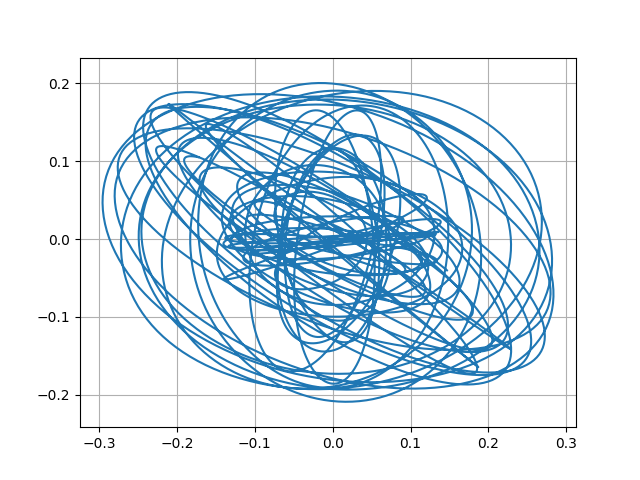

In [5]:
start = pd.to_datetime('2019-09-05 3:05+02:00')
stop = pd.to_datetime('2019-09-05 3:08+02:00')
data1 = data[start:stop].copy()
plt.figure()
plt.plot(data1.pos_x, data1.pos_z)
plt.axis('equal')
plt.grid()

<IPython.core.display.Javascript object>


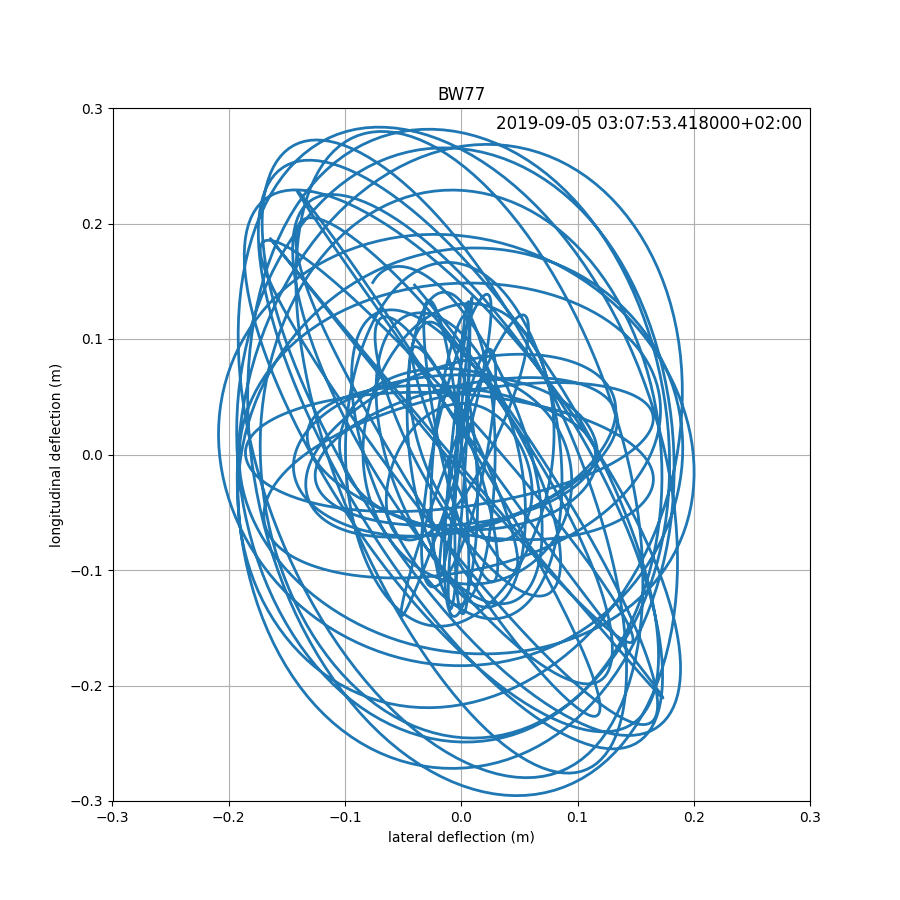

In [4]:
fig = plt.figure(figsize=(9,9))
ax = plt.axes(xlim=(-0.3, 0.3), 
              ylim=(-0.3, 0.3), 
              xlabel="lateral deflection (m)", 
              ylabel="longitudinal deflection (m)",
              title="BW77"
             )
line, = ax.plot([], [], lw=2)
ax.grid()

# fig.figimage(watermark, 210, 1050, zorder=1, alpha=.5)
# time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
text = ax.text(0.55, 0.97, '', transform=ax.transAxes,  fontsize=12)


def init():
    ax.set_xlabel="Lateral deflection"
    ax.set_ylabel="Longitudinal deflection"
    line.set_data([], [])
    return line,

def animate(i):
    # x = np.linspace(0, 1, 20)
    # y = np.sin(2 * np.pi * (x - 0.01 * i))
    x = data1.pos_z.iloc[:i*5]
    y = data1.pos_x.iloc[:i*5]
    line.set_data(x, y)
    text.set_text('{}'.format(data1.index[i*5]))
    #plt.savefig("animation_frames/2019-09-05-03-40/frame_{:04d}.png".format(i), dpi=150)
    return line,

anim = FuncAnimation(fig, 
                     animate, 
                     init_func=init,
                     frames=4000, 
                     interval=100, 
                     blit=True, 
                     repeat=True,
                    )

# anim.save('BW77_2019-09-05_3:06.mp4', writer=writer)
# anim.save('Orbit.gif', writer='imagemagick')